In [1]:
import rasterio
from rasterio.mask import mask
import os, sys
import numpy as np
import sklearn
from sklearn.cluster import MiniBatchKMeans, KMeans
import fiona
from matplotlib import pyplot as plt
from scipy.misc import bytescale
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

## write my own majority filter..
def majority_agg(arr, factor):
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0, arr.shape[0], factor)
    col_sets = np.arange(0, arr.shape[1], factor)
    
    # allocate new array
    new_arr = np.zeros((row_sets.size, col_sets.size))
    for i,r in enumerate(row_sets[:-2]):
        for j,c in enumerate(col_sets[:-2]):
            
            # get the start/stop for the slice
            row_start = int(row_sets[i])
            row_end = int(row_sets[i+1])
            col_start = int(col_sets[j])
            col_end = int(col_sets[j+1])
                        
            #get the pixels
            pixels = arr[row_start:row_end, col_start:col_end]
            
            # get the value (majority)
            val = np.argmax(np.bincount(pixels.ravel()))
            
            new_arr[i,j] = val
    
    return new_arr

# function to plot rgb image with mask
def plot_rgb(arr):
    
    if arr.shape[-1] != 3:
        raise Exception('Input needs to be 3 band, and band channel needs to be last channel')
        
    if type(arr) is np.ma.MaskedArray:
        # build alpha channel        
        mask = np.ma.getmask(arr[:,:,0])
        mask = ~mask * 255
        
        # add the mask to the array (ise earthpy bytescale)
        plot_arr = np.dstack((bytescale(arr),mask))
        
        # plot it
        plt.imshow(plot_arr)
        plt.show()
        
    else: #no mask, no worries
        plt.imshow(plot_arr)
        
    return plot_arr

In [2]:
# specify some shape files
sjer_aoi_shp = '../shp/planet_sub_mosaic_intersect_SJER_AOI.shp'
sjer_bound_shp = '../shp/Export_Output.shp'

# specify some image files for March 12
planet_mar12 = '../march_2017_planet_scenes/20170312_180045_0e3a/20170312_180045_0e3a_3B_AnalyticMS_SR.tif'
l8_mar12_base = '../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_'
l8_mar12_bands = [l8_mar12_base + b + '.tif' for b in ['band2', 'band3', 'band4', 'band5']]
l8_mar12_bands

nclass=7

In [3]:
## load images as numpy arrays
# load aoi
with fiona.open(sjer_aoi_shp, "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

# first planet
with rasterio.open(planet_mar12, 'r') as src:
    pl_arr = mask(src, geoms, crop=True, nodata=0, all_touched=True)[0]
    
# move bands to back
pl_arr = np.rollaxis(pl_arr, 0,3)
    
# then landsat
l_ls = []
for lb in l8_mar12_bands:
    with rasterio.open(lb, 'r') as src:
        temp_arr = mask(src, geoms, crop=True, nodata=0, all_touched=True)[0].squeeze()
    
    l_ls.append(temp_arr)

# make list to array and roll bands to back
l8_arr = np.ma.array(l_ls)
l8_arr = np.rollaxis(l8_arr, 0,3)

## explicitly set the mask
l8_arr = np.ma.masked_equal(l8_arr, 0).astype('float32')/10000.
pl_arr = np.ma.masked_equal(pl_arr, 0).astype('float32')/10000.

pl_rgb = pl_arr[:,:,[2,1,0]]
l8_rgb = l8_arr[:,:,[2,1,0]]



In [19]:
pl_arr.reshape(-1,4)[::400,0].shape, l8_arr.reshape(-1,4)[::40,0].shape

((14494,), (1462,))

### train a K means classifier on PlanetScope 4-band SR data, and apply to Landsat 8 (4 bands)

## Look at silhoutte plots for planet and landsat k means classifiers

In [48]:
from sklearn.metrics import silhouette_samples, silhouette_score
# import matplotlib.cm as cm
from matplotlib.pyplot import cm

In [62]:
# Data is contained in 
# pred_data_l8_l8 -> L8 classifier, L8 image
# pred_data_l8_pl -> L8 classifier, PL image
# pred_data_pl_l8 -> PL classifier, L8 image
# pred_data_pl_pl -> PL classifier, PL image


# specify a range of cluster values
range_n_clusters = [2, 3, 4, 5, 6, 7]
range_n_clusters = [3,4,5,6,7,8]

# make the X array
X = pl_arr.reshape(-1,4)
mask = np.ma.getmask(X)
mask_inds = np.where(~mask.all(axis=1))[0]
Xt = X[mask_inds,:]
Xt.shape, X.shape

X = Xt[::200]

C:\anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


For n_clusters = 3 The average silhouette_score is : 0.427218


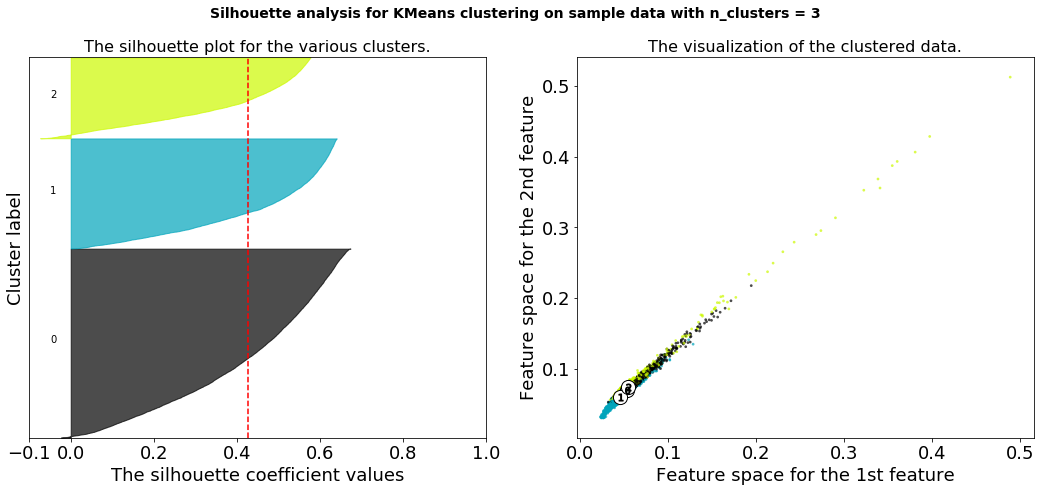

For n_clusters = 4 The average silhouette_score is : 0.432638


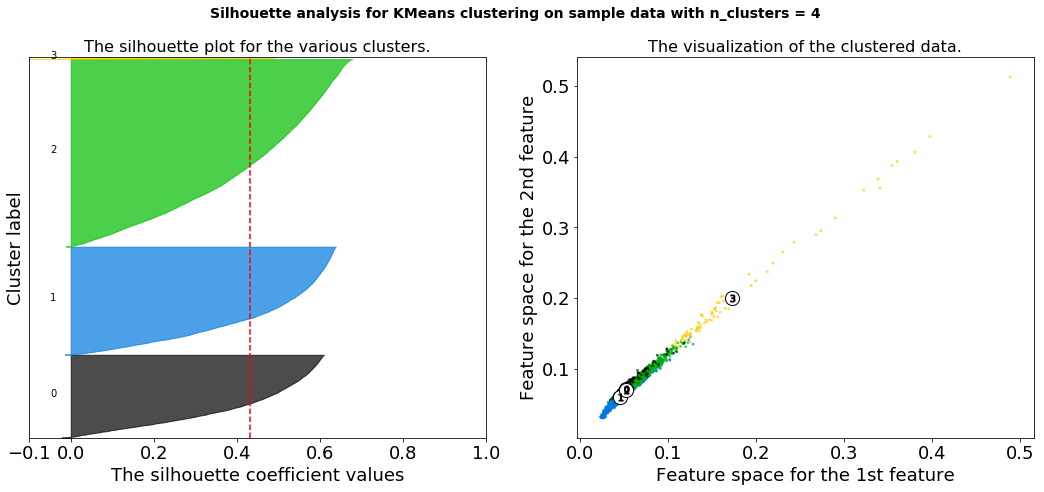

For n_clusters = 5 The average silhouette_score is : 0.402552


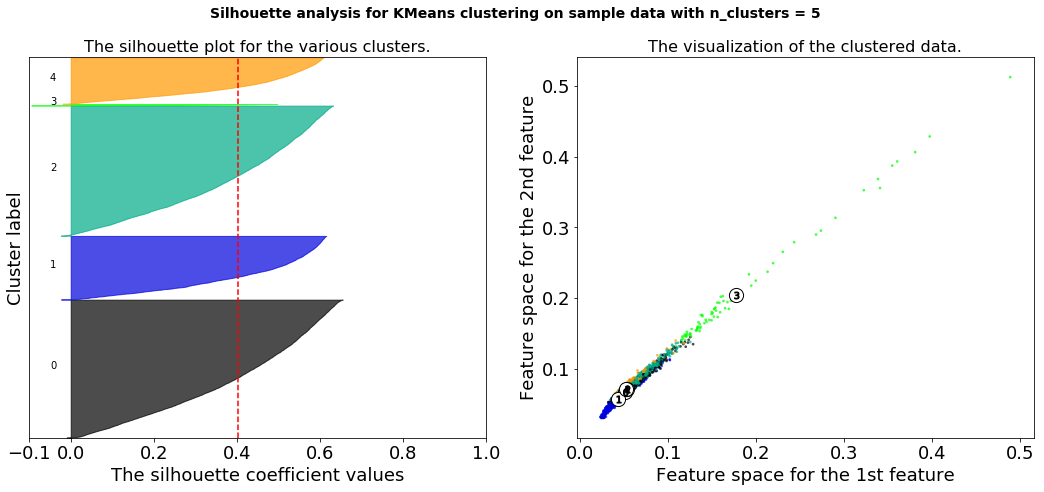

For n_clusters = 6 The average silhouette_score is : 0.372559


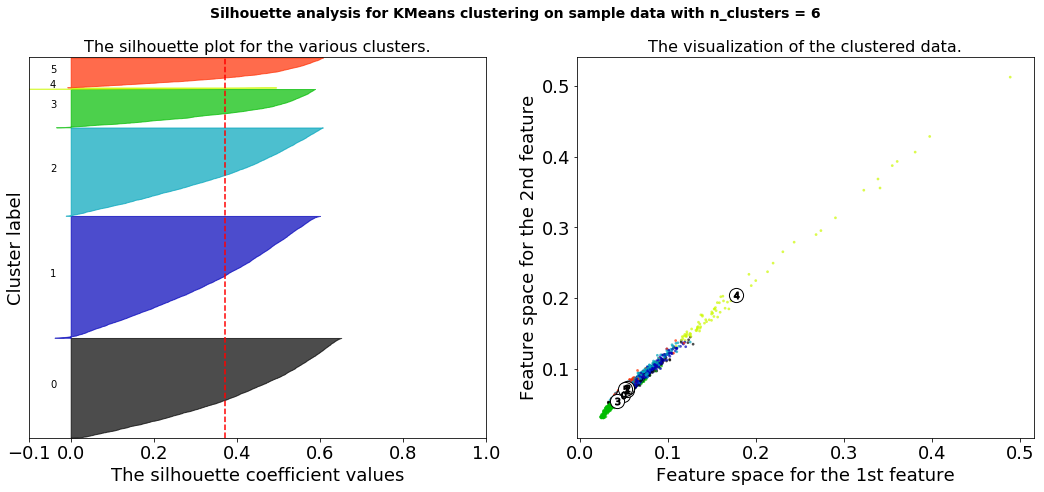

For n_clusters = 7 The average silhouette_score is : 0.38111


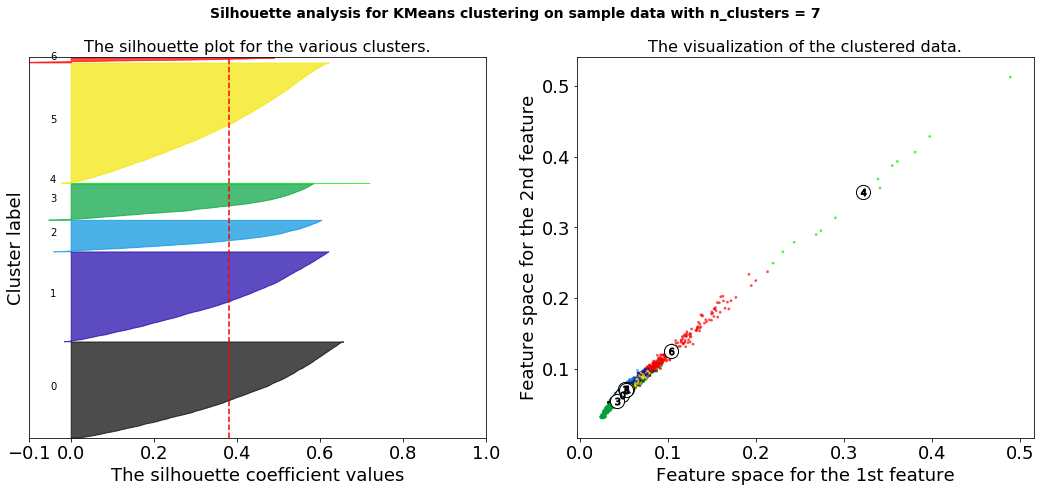

For n_clusters = 8 The average silhouette_score is : 0.364049


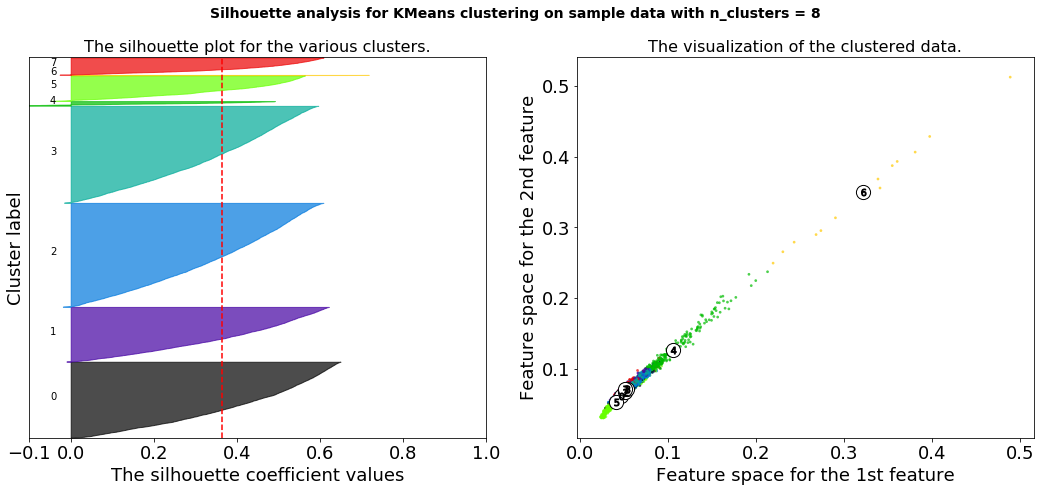

In [63]:
sil_scores = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sil_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

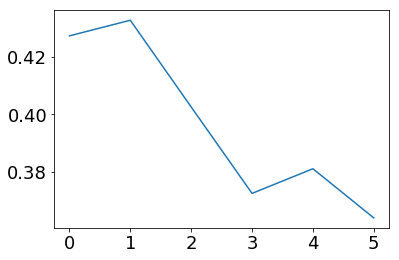

In [64]:
plt.plot(sil_scores)